In [1]:
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
pd.options.mode.chained_assignment = None

In [2]:
%matplotlib inline

In [3]:
train = pd.read_csv('BikeSharingDemand/train.csv')
test = pd.read_csv('BikeSharingDemand/test.csv')
submit = pd.read_csv('BikeSharingDemand/sampleSubmission.csv')

In [4]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [5]:
# 觀察資料，有沒有空值
# 都沒有空值，不一定是好事，有可能提供資料的人用不好的方法進行補值的動作
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [7]:
train.describe()
# 可以看到 count 中，50%= 145，75%=284，但 max 來到 977，差距有點大，可能有 outlier

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
test.describe()
# 沒有 casual 跟 refistered 這兩欄資料，所以在 train model 可以忽略這兩欄內容

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


# Feature Engineering

In [9]:
# 資料大於或小於平均加上或減掉 3 倍標準差，就可以斷定它是 outlier
# 去除 outlier
# 可以看出去掉 100 多筆的資料

print("Shape Of The Before Outliers: ", train.shape)
train = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())]
print("Shape Of The After Outliers: ", train.shape)

Shape Of The Before Outliers:  (10886, 12)
Shape Of The After Outliers:  (10739, 12)


In [13]:
# 資料前處理都是 test 跟 train 一起處理，所以會把兩個資料先合併，一起做 Feature Engineering
data = train.append(test) # 合併資料
data.reset_index(inplace=True) # 重新給予 index 編號，將原本 index 新增成一個欄位。inplace=True 代表在原資料上進行修改
data.drop('index', inplace=True, axis=1) # drop 掉原本錯誤的 index。axis=1 表示欄位、列 (column)，axis=0 表示觀測值、行 (row)

C:\Users\cody8\AppData\Local\Temp\ipykernel_4252\1116913677.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train.append(test) # 合併資料


In [17]:
# 把欄位 datetime 拆成 model 可以讀的資料型態
# split() 用空格做切割
# 用 datetime.strptime() 得到 weekday 跟 month 的資訊
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(':')[0]).astype('int')
data["year"] = data.datetime.apply(lambda x : x.split()[0].split('-')[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').month)

In [51]:
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.003200,0.0,1.0,1.0,2011-01-01,5,2011,5,1
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.997900,12.0,24.0,36.0,2011-01-01,10,2011,5,1
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.001200,26.0,30.0,56.0,2011-01-01,11,2011,5,1
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.001200,29.0,55.0,84.0,2011-01-01,12,2011,5,1
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.999500,47.0,47.0,94.0,2011-01-01,13,2011,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17227,2012-12-29 12:00:00,1,0,0,3,8.20,12.120,100,9.573772,NaN,NaN,NaN,2012-12-29,12,2012,5,12
17228,2012-12-29 13:00:00,1,0,0,3,8.20,12.120,100,9.573772,NaN,NaN,NaN,2012-12-29,13,2012,5,12
17229,2012-12-29 15:00:00,1,0,0,2,9.84,12.120,87,7.449305,NaN,NaN,NaN,2012-12-29,15,2012,5,12
17230,2012-12-29 23:00:00,1,0,0,2,10.66,12.120,60,25.859701,NaN,NaN,NaN,2012-12-29,23,2012,5,12


C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

[Text(0.5, 0, 'windspeed'), Text(0.5, 1.0, 'distribution of windspeed')]

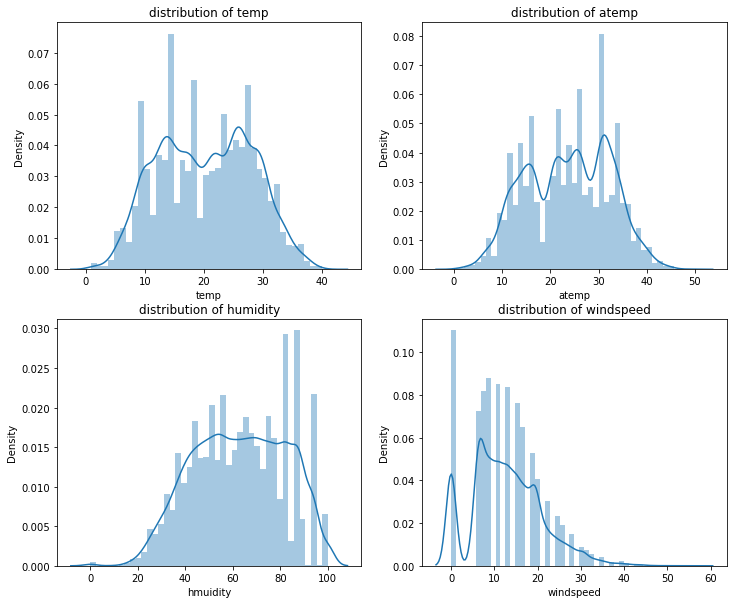

In [25]:
# 畫出以下資料的資料分布圖
fig, axes = plt.subplots(nrows=2, ncols=2) # 宣告要畫 2*2 的圖
fig.set_size_inches(12, 10) # 每個圖的大小是 12*10
# 用 distribution plot，distplot() 畫資料分布圖，直方圖、荷密度函數
sns.distplot(data["temp"], ax=axes[0][0])
sns.distplot(data["atemp"], ax=axes[0][1])
sns.distplot(data["humidity"], ax=axes[1][0])
sns.distplot(data["windspeed"], ax=axes[1][1])

axes[0][0].set(xlabel='temp', title="distribution of temp") # 為 x 軸跟 title 命名
axes[0][1].set(xlabel='atemp', title="distribution of atemp")
axes[1][0].set(xlabel='hmuidity', title="distribution of humidity")
axes[1][1].set(xlabel='windspeed', title="distribution of windspeed")

# 觀察發現，windspeed 的圖有異常，風速是連續數值的欄位，中間不應該有空隙，推論測量風速的儀器不準確或不穩定，將沒有測到的值都以 0 紀錄

In [26]:
# 處理 windspeed 資料
# 將風速是 0 與不是 0 的資料分開
dataWind0 = data[data['windspeed']==0]
dataWindNot0 = data[data['windspeed']!=0]

# 用 Random Forest Regression 預測風速 = 0，實際上的值可能是多少
# Random Forest Regression，這個演算法有隨機的成分，random_state 可以想像成洗牌的方式，如果設一樣，就會得到一樣的結果
rfModel_wind = RandomForestRegressor(n_estimators=1000, random_state=42) # 用 1000 棵樹，，random_state 可以是任意值
# 列出要預測風速的欄位
windColumns = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']
# 用 fit(要train的資料, 要train的資料的結果) train model，
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0['windspeed'])

# 用 predict() 預測風速是多少
wind0Values = rfModel_wind.predict(X=dataWind0[windColumns])
# 將風速的值放到原本風速是 0 的位置
dataWind0.loc[:, 'windspeed'] = wind0Values
# 將一開始拆開的 windspeed 資料合併
data = dataWindNot0.append(dataWind0)
# index 重新編號
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

C:\Users\cody8\AppData\Local\Temp\ipykernel_4252\1549455598.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = dataWindNot0.append(dataWind0)


C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='windspeed', ylabel='Density'>

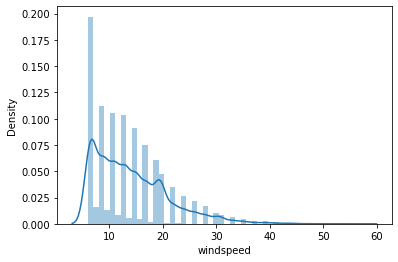

In [27]:
sns.distplot(data['windspeed'])

#### Feature Engineearing 結束

In [28]:
# 將資料重新分為 train 跟 test，依據 datetime 重新排序
dataTrain = data[pd.notnull(data['count'])].sort_values(by=['datetime']) # 腳踏車數量不是空的，就是 Train 
dataTest = data[~pd.notnull(data['count'])].sort_values(by=['datetime']) # 腳踏車數量是空的，就是 Test 
# 萃取出 datetime 這個 column，因為最後要 submit 的格式需要用到  
datetimecol = dataTest['datetime']
# yLabels 就是 training data 的 y，每小時腳踏車被租借出去的數量
yLabels = dataTrain['count']
yLabelsLog = np.log(yLabels) # 用 numpy 的 log()函式，對 y 取 log

In [29]:
# 先丟掉之後 train model 用不到的欄位
dropFeatures = ['casual', 'count', 'datetime', 'date', 'registered']
dataTrain = dataTrain.drop(dropFeatures, axis=1) # axis=1，列
dataTest = dataTest.drop(dropFeatures, axis=1)

C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\cody8\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'yLabelsLog'), Text(0.5, 1.0, 'distribution of yLabelsLog')]

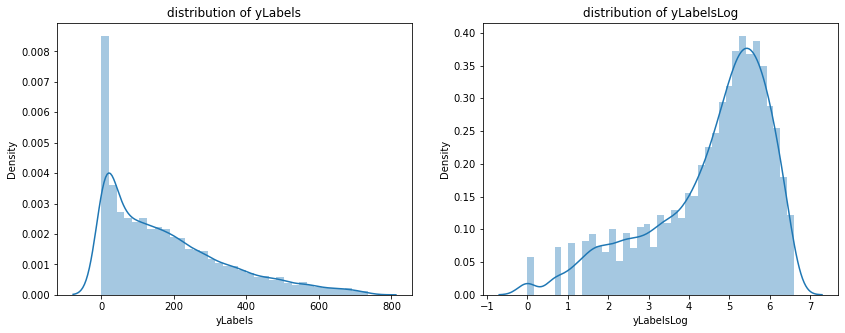

In [44]:
# 這個 y 就是每小時腳踏車租借的數量的分布，有點不符合常態分布
# 很多 Machine Learning 的 Model 是在常態分佈的假設前提下
# 因此要將這個分布拉回中間一點，最常見的方法就是取 log

fig, axes = plt.subplots(nrows=1, ncols=2) # 宣告要畫 1*2 的圖
fig.set_size_inches(14, 5)
# 用 distribution plot，distplot() 畫資料分布圖，直方圖、荷密度函數
sns.distplot(yLabels, ax=axes[0])
sns.distplot(yLabelsLog, ax=axes[1])

axes[0].set(xlabel='yLabels', title="distribution of yLabels") # 為 x 軸跟 title 命名
axes[1].set(xlabel='yLabelsLog', title="distribution of yLabelsLog")

In [46]:
rfModel = RandomForestRegressor(n_estimators=1000, random_state=42)
yLabelsLog = np.log(yLabels)
# train
rfModel.fit(dataTrain, yLabelsLog)
# 這裡是 predict dataTrain
preds = rfModel.predict(X=dataTrain)

In [47]:
preds

array([2.98653831, 3.4419026 , 3.21407121, ..., 5.1705029 , 4.93288879,
       4.55005981])

In [49]:
# 實際要提交的是 predict dataTest
predsTest = rfModel.predict(X=dataTest)
submission = pd.DataFrame({
    'datetime': datetimecol, 
    'count': [max(0, x) for x in np.exp(predsTest)]
})
submission.to_csv('blik_predictions_RF.csv', index=False)

In [50]:
submission

,datetime,count
9442,2011-01-20 00:00:00,10.741879
16365,2011-01-20 01:00:00,4.853517
16366,2011-01-20 02:00:00,2.925504
9443,2011-01-20 03:00:00,3.048532
9444,2011-01-20 04:00:00,2.582506
...,...,...
15063,2012-12-31 19:00:00,287.244830
15064,2012-12-31 20:00:00,197.939089
15065,2012-12-31 21:00:00,137.997122
15066,2012-12-31 22:00:00,108.633856
